# KNN on Amazon Food Reviews

### Using Bag of Words(BoW) Technique

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 Number of users: 256,059 Number of products: 74,258 Timespan: Oct 1999 - Oct 2012 Number of Attributes/Columns in data: 10

Attribute Information:

1. index
2. Id
3. ProductId - unique identifier for the product
4. UserId - unqiue identifier for the user
5. ProfileName
6. HelpfulnessNumerator - number of users who found the review helpful
7. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
8. Score - rating between 1 and 5
9. Time - timestamp for the review
10. Summary - brief summary of the review
11. Text - text of the review
12. ProcessedText - Cleaned & Preprocessed Text of the review

**Objective: Given Amazon Food reviews, convert all the reviews into a vector using four techniques: BoW; tf_idf; Avg_w2v and tf_idf_w2v and then apply 10-fold cross validation in KNN. Use both brute force and KD-Tree implementation of KNN to find neighbours**

[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

**Loading the data**

SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently. Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter

from wordcloud import WordCloud

In [3]:
connection = sqlite3.connect('FinalAmazonFoodReviewsDataset.sqlite')

In [4]:
data = pd.read_sql_query("SELECT * FROM Reviews", connection)

In [5]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,have bought sever the vital can dog food produ...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut the pean...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this confect that has been around few centuri ...
3,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price there was wide assort ...
4,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,Positive,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair for taffi and order this five po...


In [6]:
data.shape

(364171, 12)

In [7]:
data["Score"].value_counts()

Positive    307061
Negative     57110
Name: Score, dtype: int64

In [8]:
def changingScores(score):
    if score == "Positive":
        return 1
    else:
        return 0

In [9]:
# changing score
# Positive = 1
# Negative = 0
actualScore = list(data["Score"])                                                                                         
positiveNegative = list(map(changingScores, actualScore)) #map(function, list of numbers)
data['Score'] = positiveNegative

In [10]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,have bought sever the vital can dog food produ...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut the pean...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this confect that has been around few centuri ...
3,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price there was wide assort ...
4,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,1,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair for taffi and order this five po...


In [11]:
allPositiveReviews = data[(data["Score"] == 1)]

In [12]:
allPositiveReviews.shape

(307061, 12)

In [13]:
positiveReviews_5000 = allPositiveReviews[:5000]

In [14]:
positiveReviews_5000.shape

(5000, 12)

In [15]:
positiveReviews_5000.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,have bought sever the vital can dog food produ...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this confect that has been around few centuri ...
3,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price there was wide assort ...
4,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,1,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair for taffi and order this five po...
5,6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,1,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,this saltwat taffi had great flavor and was ve...


In [16]:
allNegativeReviews = data[(data["Score"] == 0)]

In [17]:
allNegativeReviews.shape

(57110, 12)

In [18]:
negativeReviews_5000 = allNegativeReviews[:5000]

In [19]:
negativeReviews_5000.shape

(5000, 12)

In [20]:
negativeReviews_5000.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut the pean...
11,12,13,B0009XLVG0,A327PCT23YH90,LT,1,1,0,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...,cat have been happili eat felida platinum for ...
15,16,17,B001GVISJM,A3KLWF6WQ5BNYO,Erica Neathery,0,0,0,1348099200,poor taste,I love eating them and they are good for watch...,love eat them and they are good for watch and ...
25,26,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,0,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan...",the candi just red flavor just plan and chewi ...
45,47,51,B001EO5QW8,A108P30XVUFKXY,Roberto A,0,7,0,1203379200,Don't like it,"This oatmeal is not good. Its mushy, soft, I d...",this oatmeal not good it mushi soft dont like ...


In [21]:
frames_10000 = [positiveReviews_5000, negativeReviews_5000]

In [22]:
FinalPositiveNegative = pd.concat(frames_10000)

In [23]:
FinalPositiveNegative.shape

(10000, 12)

In [24]:
#Sorting FinalDataframe by "Time"
FinalSortedPositiveNegative_10000 = FinalPositiveNegative.sort_values('Time', axis=0, ascending=True, inplace=False)

In [25]:
FinalSortedPositiveNegativeScore_10000 = FinalSortedPositiveNegative_10000["Score"]

In [26]:
FinalSortedPositiveNegative_10000.shape

(10000, 12)

In [27]:
FinalSortedPositiveNegativeScore_10000.shape

(10000,)

In [28]:
FinalSortedPositiveNegative_10000.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
772,1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,this was realli good idea and the final produc...
771,1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,just receiv shipment and could hard wait tri t...
5822,7427,8111,B0000EIE2Z,A3M174IC0VXOS2,Gail Cooke,3,3,1,1075420800,BEST BLUEBERRIES,In the winter when fresh blueberries exceed ou...,the winter when fresh blueberri exceed our foo...
2418,3481,3783,B00016UX0K,AF1PV3DIC0XM7,Robert Ashton,1,2,1,1081555200,Classic Condiment,Mae Ploy Sweet Chili Sauce is becoming a stand...,mae ploy sweet chili sauc becom standard condi...
5206,6790,7432,B0001E1IME,A2IKCTD1I73PLW,Adeba,2,8,1,1083456000,amazon monopoly/ripoff,love the snack. wanted to buy a bunch.<p>ship...,love the snack want buy bunch ship amazon more...


## Bag of Words(BoW)

In [30]:
positive_reviews = FinalSortedPositiveNegative_10000[(FinalSortedPositiveNegative_10000["Score"] == 1)]
negative_reviews = FinalSortedPositiveNegative_10000[(FinalSortedPositiveNegative_10000["Score"] == 0)]

In [34]:
positive_reviews.shape, negative_reviews.shape

((5000, 12), (5000, 12))

In [35]:
positive_bow_vect =  CountVectorizer(stop_words = "english")
positive_bow = positive_bow_vect.fit_transform(positive_reviews["ProcessedText"].values)

In [36]:
positive_bow.shape

(5000, 8690)

In [37]:
features_positive = positive_bow_vect.get_feature_names()
len(features_positive), type(features_positive)

(8690, list)

In [38]:
count = []
for i in range(len(features_positive)):
    total = positive_bow.getcol(i).sum() # it will give sum of all the values in 'i'th column 
    count.append(total)

In [39]:
positive_dict = dict(zip(features_positive, count))

In [40]:
sortedDict_Positive = sorted(positive_dict.items(), key = lambda positive_dict: positive_dict[1], reverse = True)

In [41]:
for i in range(200):
    print(sortedDict_Positive[i])

('like', 2171)
('tast', 2010)
('good', 1874)
('flavor', 1852)
('great', 1781)
('use', 1738)
('love', 1662)
('product', 1506)
('veri', 1482)
('coffe', 1403)
('just', 1399)
('tri', 1374)
('make', 1294)
('tea', 1040)
('buy', 870)
('realli', 866)
('time', 846)
('onli', 838)
('food', 819)
('mix', 797)
('price', 792)
('littl', 761)
('eat', 750)
('best', 748)
('drink', 746)
('order', 737)
('dont', 736)
('bag', 710)
('amazon', 683)
('store', 667)
('becaus', 640)
('better', 637)
('ive', 581)
('recommend', 578)
('sugar', 576)
('cup', 563)
('ani', 546)
('chip', 539)
('high', 511)
('year', 509)
('pack', 496)
('want', 494)
('work', 492)
('sweet', 481)
('snack', 478)
('look', 471)
('water', 468)
('brand', 467)
('delici', 462)
('milk', 447)
('day', 443)
('purchas', 440)
('box', 439)
('nice', 439)
('favorit', 432)
('chocol', 429)
('enjoy', 424)
('free', 422)
('perfect', 407)
('packag', 399)
('say', 398)
('thing', 398)
('easi', 395)
('mani', 394)
('bought', 393)
('fresh', 392)
('add', 388)
('differ', 3

In [42]:
def PlotWordCloud(frequency):
    worcloudPlot = WordCloud(background_color="white", width=1500, height=1000)
    worcloudPlot.generate_from_frequencies(frequencies=frequency)
    plot.figure(figsize=(15,10))
    plot.imshow(worcloudPlot, interpolation="bilinear")
    plot.axis("off")
    plot.show()

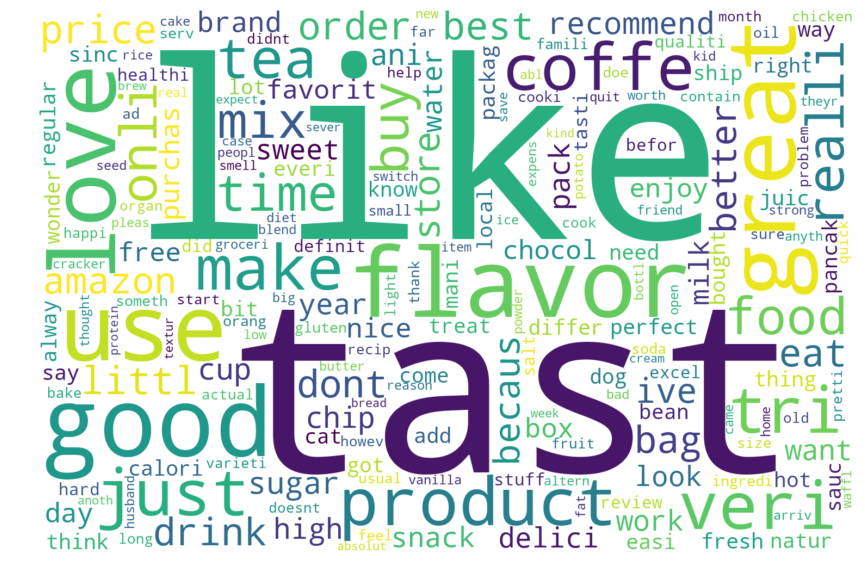

In [43]:
PlotWordCloud(positive_dict)

**This is a Word Cloud for all the positive reviews in the corpus.**<br>
**This Word Cloud plot correponds to the most frequent words in all positive reviews.**

How I have plotted this word cloud. Now BoW representation is based on the count of the word in a document. If a word Wi occurs in many document then the sum of its column will be high. Therefore, I have just calculated the sum of all the column and created the dictionary where keys are the features and values are the sum of that column. I feeded this dictionary to the wordcloud and plotted the same. the same procedure is followed for negative reviews as well

In [44]:
negative_bow_vect =  CountVectorizer(stop_words = "english")
negative_bow = negative_bow_vect.fit_transform(negative_reviews["ProcessedText"].values)

In [45]:
negative_bow.shape

(5000, 9648)

In [46]:
features_negative = negative_bow_vect.get_feature_names()
len(features_negative), type(features_negative)

(9648, list)

In [47]:
count = []
for i in range(len(features_negative)):
    total = negative_bow.getcol(i).sum() # it will give sum of all the values in 'i'th column 
    count.append(total)

In [48]:
negative_dict = dict(zip(features_negative, count))

In [49]:
sortedDict_Negative = sorted(negative_dict.items(), key = lambda negative_dict: negative_dict[1], reverse = True)

In [50]:
for i in range(200):
    print(sortedDict_Negative[i])

('tast', 3153)
('like', 2911)
('product', 2408)
('just', 1775)
('tri', 1662)
('flavor', 1656)
('veri', 1597)
('use', 1407)
('good', 1345)
('coffe', 1198)
('tea', 1147)
('buy', 1135)
('food', 1106)
('dog', 1040)
('dont', 1038)
('order', 1020)
('becaus', 979)
('make', 940)
('time', 919)
('drink', 918)
('box', 915)
('onli', 897)
('realli', 885)
('eat', 869)
('bag', 851)
('look', 836)
('amazon', 821)
('packag', 802)
('love', 769)
('review', 712)
('bought', 707)
('purchas', 704)
('better', 691)
('chocol', 691)
('ani', 689)
('did', 675)
('water', 666)
('bad', 665)
('disappoint', 661)
('think', 643)
('want', 634)
('sugar', 630)
('say', 624)
('mix', 619)
('know', 616)
('price', 608)
('didnt', 604)
('ingredi', 566)
('smell', 560)
('ive', 557)
('cup', 553)
('thought', 549)
('great', 548)
('littl', 544)
('way', 542)
('got', 523)
('brand', 515)
('thing', 510)
('store', 502)
('someth', 496)
('open', 491)
('receiv', 484)
('item', 483)
('treat', 480)
('differ', 472)
('sweet', 465)
('ginger', 464)
('m

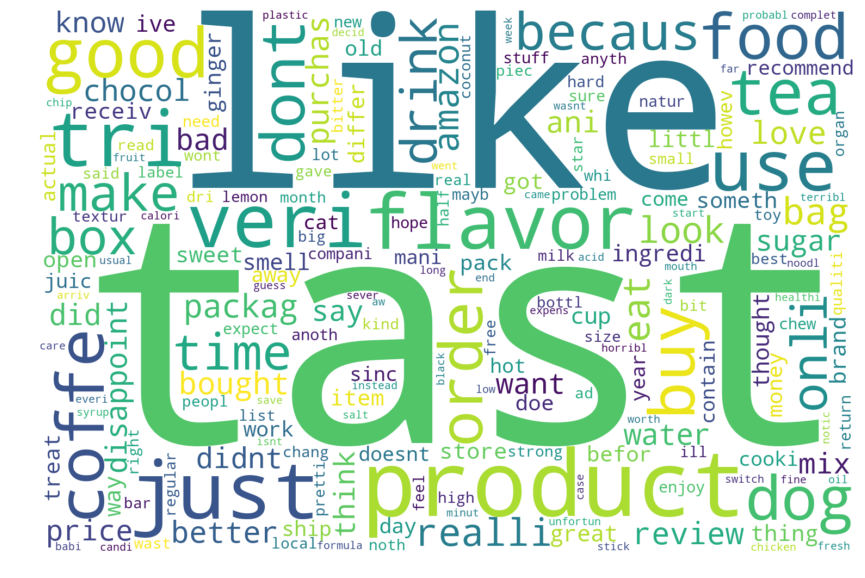

In [51]:
PlotWordCloud(negative_dict)

**This is a Word Cloud for all the negative reviews in the corpus.**<br>
**This Word Cloud plot correponds to the most frequent words in all negative reviews.**

In [29]:
count_vect = CountVectorizer()

In [30]:
BoW = count_vect.fit_transform(FinalSortedPositiveNegative_10000["ProcessedText"].values)

In [31]:
print(type(BoW))

<class 'scipy.sparse.csr.csr_matrix'>


In [32]:
BoW.shape

(10000, 13033)

It means that there are 10000 reviews means there are 10000 rows and there are total 13033 unique words in all the reviews.

In [33]:
#Standardizing our data matrix
BoW_Standardized = StandardScaler(with_mean = False).fit_transform(BoW)
print(BoW_Standardized.shape)
print(type(BoW_Standardized))

(10000, 13033)
<class 'scipy.sparse.csr.csr_matrix'>


C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Brute Force Implementation

In [230]:
X_BOW = BoW_Standardized

In [231]:
Y_BOW = FinalSortedPositiveNegativeScore_10000

In [232]:
X_BOW.shape

(10000, 13033)

In [233]:
Y_BOW.shape

(10000,)

In [234]:
X_BOW_1, X_BOW_test, Y_BOW_1, Y_BOW_test = cross_validation.train_test_split(X_BOW, Y_BOW, test_size = 0.3, random_state = 0)

myList = list(range(0,50))
neighbors = list(filter(lambda x: x%2!=0, myList))  #This will give a list of odd numbers only ranging from 0 to 50

CV_Scores = []

for k in neighbors:
    KNN = KNeighborsClassifier(n_neighbors = k, algorithm = 'brute')
    scores = cross_val_score(KNN, X_BOW_1, Y_BOW_1, cv = 10, scoring='accuracy')
    CV_Scores.append(scores.mean())

In [236]:
CV_Scores

[0.5987215898108248,
 0.629004296801772,
 0.6318622554040199,
 0.6367128775481465,
 0.6335708309025704,
 0.6418657408338735,
 0.640004515752656,
 0.6324306277009895,
 0.6297155186614084,
 0.6260042868892152,
 0.6217177481120224,
 0.6215744822219754,
 0.6267238781536871,
 0.6282914317900941,
 0.626285100290292,
 0.6271420411062063,
 0.6274269367313579,
 0.6229969224426988,
 0.6167085378891445,
 0.6035644340965127,
 0.5881368577137038,
 0.5759976553888011,
 0.5638611046728084,
 0.5512880224536902,
 0.5405722932962254]

In [237]:
print(max(CV_Scores))
print(CV_Scores.index(max(CV_Scores)))
print(neighbors[5])

0.6418657408338735
5
11


In [238]:
maxScoreIndex = CV_Scores.index(max(CV_Scores))

In [239]:
best_k = neighbors[maxScoreIndex]

In [240]:
best_k

11

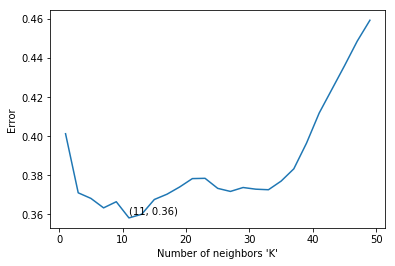

In [241]:
error = []

for a in CV_Scores:
    x = 1 - a
    error.append(x)
    
plot.plot(neighbors, error)

minError1 = min(error)
minError = np.round(minError1, 2)

plot.xlabel("Number of neighbors 'K'")
plot.ylabel("Error")
for xy in zip(neighbors, np.round(error,2)):
    if xy == (best_k, minError):
        plot.annotate(xy,xy)

plot.show()

In [242]:
KNN_best = KNeighborsClassifier(n_neighbors = best_k, algorithm = 'brute')

KNN_best.fit(X_BOW_1, Y_BOW_1)

prediction = KNN_best.predict(X_BOW_test)

accuracyTest = accuracy_score(Y_BOW_test, prediction) * 100

print("Accuracy of the knn classifier for best k values of "+str(best_k)+" is: "+str(accuracyTest)+"%")

Accuracy of the knn classifier for best k values of 11 is: 65.3%


### KD Tree Implementation

In [243]:
KNN_best = KNeighborsClassifier(n_neighbors = best_k, algorithm = 'kd_tree')

KNN_best.fit(X_BOW_1, Y_BOW_1)

prediction = KNN_best.predict(X_BOW_test)

accuracyTest = accuracy_score(Y_BOW_test, prediction) * 100

print("Accuracy of the knn classifier for best k values of "+str(best_k)+" is: "+str(accuracyTest)+"%")

C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:212: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


Accuracy of the knn classifier for best k values of 11 is: 65.3%


## TFIDF

In [53]:
positive_reviews = FinalSortedPositiveNegative_10000[(FinalSortedPositiveNegative_10000["Score"] == 1)]
negative_reviews = FinalSortedPositiveNegative_10000[(FinalSortedPositiveNegative_10000["Score"] == 0)]

In [54]:
Positive_tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), stop_words = "english")
Positive_tf_idf = Positive_tf_idf_vect.fit_transform(positive_reviews["ProcessedText"].values)

In [55]:
Positive_tf_idf.shape

(5000, 114651)

In [56]:
features = Positive_tf_idf_vect.get_feature_names()

In [58]:
idfValues = Positive_tf_idf_vect.idf_

In [61]:
d = dict(zip(features, 9 - idfValues))

In [62]:
sortedDict = sorted(d.items(), key = lambda d: d[1], reverse = True)

In [63]:
for i in range(200):
    print(sortedDict[i])

('like', 6.809072442421418)
('tast', 6.765368008186689)
('great', 6.763992492151379)
('good', 6.73466078043391)
('love', 6.689725684788852)
('flavor', 6.590032302691801)
('use', 6.568508292946707)
('just', 6.50636578331954)
('veri', 6.503690792870237)
('product', 6.470097075582087)
('tri', 6.467323148699362)
('make', 6.391361607896317)
('buy', 6.114608605976726)
('onli', 6.072907876777782)
('time', 6.060468186302143)
('realli', 6.049279258384337)
('best', 5.968767617525185)
('price', 5.95030555468545)
('littl', 5.909095286038787)
('dont', 5.886181026515912)
('order', 5.886181026515912)
('amazon', 5.849077276312534)
('store', 5.833492545295836)
('eat', 5.817661080079155)
('coffe', 5.8141086784747875)
('becaus', 5.806965790962407)
('recommend', 5.797964830103432)
('better', 5.790705270090627)
('mix', 5.726773729244833)
('ive', 5.650123319469437)
('ani', 5.631075124498743)
('high', 5.624644234168453)
('food', 5.594074168083775)
('bag', 5.591854411345462)
('drink', 5.580681110747337)
('yea

In [66]:
def PlotWordCloud(frequency):
    worcloudPlot = WordCloud(background_color="white", width=1500, height=1000)
    worcloudPlot.generate_from_frequencies(frequencies=frequency)
    plot.figure(figsize=(15,10))
    plot.imshow(worcloudPlot, interpolation="bilinear")
    plot.axis("off")
    plot.show()

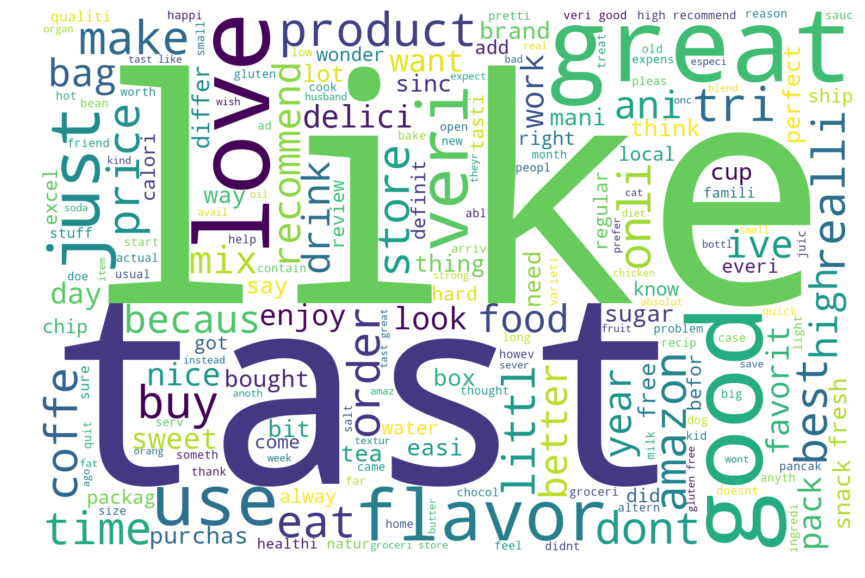

In [67]:
PlotWordCloud(d)

**This is a Word Cloud for all the positive reviews in the corpus.**<br>
**This Word Cloud plot correponds to the most frequent words in all positive reviews based on IDF values. More is the IDF Value for a word the less frequent is the word in the corpus.**

How I have plotted this word cloud.
Now formulae for IDF(D,Wi) = (ln(N+1 / ni+1) + 1) where 'N' is total number of documents in a corpus and 'ni' is the total number of documents where word 'Wi' occurs. Hence, I got all the idf values from idf_ attribute and I got corresponding features from get_features_names() function. Now since, the highest possible idf value can be 8.88, hence, I subtracted all the idf values from '9' which leads to the highest idf value of the most frequently occuring word. Now I created dictionary where features are the keys and modified idf value are the values and I feeded this to the word cloud and plot the same.
The same is done for negative reviews as well.

In [68]:
Negative_tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), stop_words = "english")
Negative_tf_idf = Negative_tf_idf_vect.fit_transform(negative_reviews["ProcessedText"].values)

In [69]:
Negative_tf_idf.shape

(5000, 139161)

In [70]:
features_neg = Negative_tf_idf_vect.get_feature_names()

In [71]:
negIDF = Negative_tf_idf_vect.idf_

In [76]:
NegD = dict(zip(features_neg, 9 - negIDF))

In [77]:
sortedDictNeg = sorted(NegD.items(), key = lambda NegD: NegD[1], reverse = True)

In [78]:
for i in range(200):
    print(sortedDictNeg[i])

('tast', 7.0050070599682215)
('like', 7.004466080782725)
('product', 6.762615081465285)
('just', 6.6496447054933165)
('veri', 6.595748937288184)
('tri', 6.565994676206391)
('good', 6.44957396719508)
('flavor', 6.4170040385096545)
('use', 6.376263183183732)
('buy', 6.343270500029383)
('dont', 6.271578571573267)
('becaus', 6.170961542527858)
('onli', 6.1211746177476165)
('make', 6.113290214223468)
('time', 6.082477327793933)
('order', 6.054889371275104)
('realli', 6.047871798616457)
('look', 6.009101688151887)
('love', 5.951857145376868)
('food', 5.95030555468545)
('eat', 5.9314962227279535)
('bought', 5.923553369214017)
('disappoint', 5.889486814650411)
('ani', 5.862729365480861)
('packag', 5.861033012232683)
('better', 5.8473575854330075)
('review', 5.8473575854330075)
('did', 5.835236224900663)
('think', 5.828243189409692)
('purchas', 5.822966132308848)
('amazon', 5.810543612310291)
('box', 5.794341637734011)
('want', 5.783392623244341)
('bad', 5.781556075437039)
('say', 5.75170311228

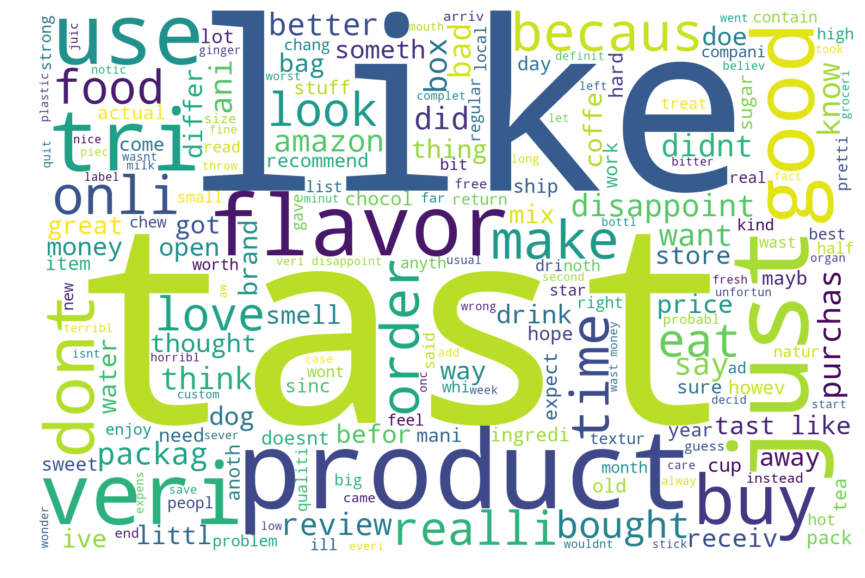

In [79]:
PlotWordCloud(NegD)

**This is a Word Cloud for all the negative reviews in the corpus.**<br>
**This Word Cloud plot correponds to the most frequent words in all negative reviews based on IDF values. More is the IDF Value for a word the less frequent is the word in the corpus.**

In [244]:
tfidf_vect = TfidfVectorizer(ngram_range = (1,2))

In [245]:
tfidf = tfidf_vect.fit_transform(FinalSortedPositiveNegative_10000["ProcessedText"].values)

In [246]:
tfidf.shape

(10000, 237703)

In [247]:
type(tfidf)

scipy.sparse.csr.csr_matrix

In [248]:
tfidf_Standardized = StandardScaler(with_mean = False).fit_transform(tfidf)
print(tfidf_Standardized.shape)
print(type(tfidf_Standardized))

(10000, 237703)
<class 'scipy.sparse.csr.csr_matrix'>


### Brute Force Implementation

In [249]:
X_tfidf = tfidf_Standardized

In [250]:
Y_tfidf = FinalSortedPositiveNegativeScore_10000

In [251]:
X_tfidf.shape

(10000, 237703)

In [252]:
Y_tfidf.shape

(10000,)

In [253]:
X_tfidf_1, X_tfidf_test, Y_tfidf_1, Y_tfidf_test = cross_validation.train_test_split(X_tfidf, Y_tfidf, test_size = 0.3, random_state = 0)

myList = list(range(0,50))
neighbors = list(filter(lambda x: x%2!=0, myList))  #This will give a list of odd numbers only ranging from 0 to 50

CV_Scores = []

for k in neighbors:
    KNN = KNeighborsClassifier(n_neighbors = k, algorithm = 'brute')
    scores = cross_val_score(KNN, X_tfidf_1, Y_tfidf_1, cv = 10, scoring='accuracy')
    CV_Scores.append(scores.mean())

In [254]:
CV_Scores

[0.49857754345271255,
 0.5014273498517344,
 0.5009983690928814,
 0.503142249852988,
 0.5009997967925882,
 0.5018569396497311,
 0.5039977629691955,
 0.5078520527592914,
 0.5144349215873035,
 0.5038553128242536,
 0.5107087985310758,
 0.5028553087426126,
 0.5045736784302475,
 0.5047167411128828,
 0.5047138868796526,
 0.5048583772619943,
 0.5104334898059559,
 0.50956878862435,
 0.5198392145406711,
 0.5088487891957796,
 0.5072828647172166,
 0.5044259221520278,
 0.5022853067047075,
 0.5044314338250836,
 0.5011434714298251]

In [255]:
print(max(CV_Scores))

0.5198392145406711


In [256]:
print(CV_Scores.index(max(CV_Scores)))

18


In [257]:
print(neighbors[CV_Scores.index(max(CV_Scores))])

37


In [258]:
maxScoreIndex = CV_Scores.index(max(CV_Scores))

In [259]:
best_k = neighbors[maxScoreIndex]

In [260]:
best_k

37

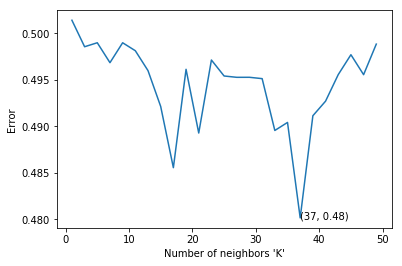

In [261]:
error = []

for a in CV_Scores:
    x = 1 - a
    error.append(x)
    
plot.plot(neighbors, error)

minError1 = min(error)
minError = np.round(minError1, 2)

plot.xlabel("Number of neighbors 'K'")
plot.ylabel("Error")
for xy in zip(neighbors, np.round(error,2)):
    if xy == (best_k, minError):
        plot.annotate(xy,xy)

plot.show()

In [262]:
KNN_best = KNeighborsClassifier(n_neighbors = best_k, algorithm = 'brute')

KNN_best.fit(X_tfidf_1, Y_tfidf_1)

prediction = KNN_best.predict(X_tfidf_test)

accuracyTest = accuracy_score(Y_tfidf_test, prediction) * 100

print("Accuracy of the knn classifier for best k values of "+str(best_k)+" is: "+str(accuracyTest)+"%")

Accuracy of the knn classifier for best k values of 37 is: 49.733333333333334%


### KD Tree Implementation

In [263]:
KNN_best = KNeighborsClassifier(n_neighbors = best_k, algorithm = 'kd_tree')

KNN_best.fit(X_tfidf_1, Y_tfidf_1)

prediction = KNN_best.predict(X_tfidf_test)

accuracyTest = accuracy_score(Y_tfidf_test, prediction) * 100

print("Accuracy of the knn classifier for best k values of "+str(best_k)+" is: "+str(accuracyTest)+"%")

C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:212: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


Accuracy of the knn classifier for best k values of 37 is: 49.733333333333334%


## Average W2V

In [322]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [323]:
i = 0
listOfSentences = []
for sentence in FinalSortedPositiveNegative_10000["ProcessedText"].values:
    subSentence = []
    for word in sentence.split():
        subSentence.append(word)
        
    listOfSentences.append(subSentence)

In [324]:
print(FinalSortedPositiveNegative_10000['ProcessedText'].values[0])
print("\n")
print(listOfSentences[0:2])
print("\n")
print(type(listOfSentences))

this was realli good idea and the final product outstand use the decal car window and everybodi ask where bought the decal made two thumb


[['this', 'was', 'realli', 'good', 'idea', 'and', 'the', 'final', 'product', 'outstand', 'use', 'the', 'decal', 'car', 'window', 'and', 'everybodi', 'ask', 'where', 'bought', 'the', 'decal', 'made', 'two', 'thumb'], ['just', 'receiv', 'shipment', 'and', 'could', 'hard', 'wait', 'tri', 'this', 'product', 'love', 'which', 'what', 'call', 'them', 'instead', 'sticker', 'becaus', 'they', 'can', 'remov', 'easili', 'daughter', 'design', 'sign', 'print', 'revers', 'use', 'her', 'car', 'window', 'they', 'print', 'beauti', 'have', 'the', 'print', 'shop', 'program', 'go', 'have', 'lot', 'fun', 'with', 'this', 'product', 'becaus', 'there', 'are', 'window', 'everywher', 'and', 'other', 'surfac', 'like', 'screen', 'and', 'comput', 'monitor']]


<class 'list'>


In [325]:
import gensim
w2vModel = gensim.models.Word2Vec(listOfSentences, size=400, min_count=5, workers=4)

In [326]:
# compute average word2vec for each review.
sentenceAsW2V = []
for sentence in listOfSentences:
    sentenceVector = np.zeros(400)
    TotalWordsPerSentence = 0
    for word in sentence:
        try:
            vect = w2vModel.wv[word]
            sentenceVector += vect
            TotalWordsPerSentence += 1
        except:
            pass
    sentenceVector /= TotalWordsPerSentence
    sentenceAsW2V.append(sentenceVector)

print(type(sentenceAsW2V))
print(len(sentenceAsW2V))
print(len(sentenceAsW2V[0]))

<class 'list'>
10000
400


In [327]:
standardized_Avg_w2v = StandardScaler().fit_transform(sentenceAsW2V)
print(standardized_Avg_w2v.shape)
print(type(standardized_Avg_w2v))

(10000, 400)
<class 'numpy.ndarray'>


### Brute Force Implementation

In [328]:
X_AvgW2V = standardized_Avg_w2v

In [329]:
Y_AvgW2V = FinalSortedPositiveNegativeScore_10000

In [330]:
X_AvgW2V.shape

(10000, 400)

In [331]:
Y_AvgW2V.shape

(10000,)

In [332]:
X_AvgW2V_1, X_AvgW2V_test, Y_AvgW2V_1, Y_AvgW2V_test = cross_validation.train_test_split(X_AvgW2V, Y_AvgW2V, test_size = 0.3, random_state = 0)

myList = list(range(0,50))
neighbors = list(filter(lambda x: x%2!=0, myList))  #This will give a list of odd numbers only ranging from 0 to 50

CV_Scores = []

for k in neighbors:
    KNN = KNeighborsClassifier(n_neighbors = k, algorithm = 'brute')
    scores = cross_val_score(KNN, X_AvgW2V_1, Y_AvgW2V_1, cv = 10, scoring='accuracy')
    CV_Scores.append(scores.mean())

In [333]:
CV_Scores

[0.6818639737748736,
 0.7198713825363491,
 0.7307250685351253,
 0.7364438580486898,
 0.7435865224797834,
 0.7470106111003726,
 0.745724686027056,
 0.7480155073202773,
 0.7508708183952562,
 0.7523014341428685,
 0.7538704137297073,
 0.7521559224756436,
 0.7567279705818641,
 0.7562971539592064,
 0.7574396041041483,
 0.7562969507517945,
 0.7567245014785746,
 0.7554385810699905,
 0.7535838842819794,
 0.7545830697030577,
 0.7551567446347558,
 0.7552975621233047,
 0.7505824525006319,
 0.753012455710551,
 0.7541551108121796]

In [334]:
print(max(CV_Scores))

0.7574396041041483


In [335]:
print(CV_Scores.index(max(CV_Scores)))

14


In [336]:
print(neighbors[CV_Scores.index(max(CV_Scores))])

29


In [337]:
maxScoreIndex = CV_Scores.index(max(CV_Scores))

In [338]:
best_k = neighbors[maxScoreIndex]

In [339]:
best_k

29

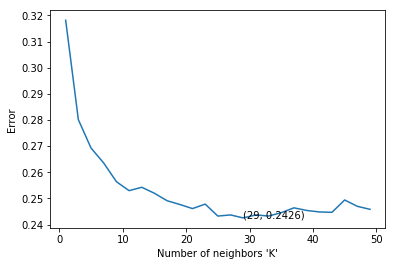

In [340]:
error = []

for a in CV_Scores:
    x = 1 - a
    error.append(x)
    
plot.plot(neighbors, error)

minError1 = min(error)
minError = np.round(minError1, 4)

plot.xlabel("Number of neighbors 'K'")
plot.ylabel("Error")
for xy in zip(neighbors, np.round(error,4)):
    if xy == (best_k, minError):
        plot.annotate(xy,xy)

plot.show()

In [341]:
KNN_best = KNeighborsClassifier(n_neighbors = best_k, algorithm = 'brute')

KNN_best.fit(X_AvgW2V_1, Y_AvgW2V_1)

prediction = KNN_best.predict(X_AvgW2V_test)

accuracyTest = accuracy_score(Y_AvgW2V_test, prediction) * 100

print("Accuracy of the knn classifier for best k values of "+str(best_k)+" is: "+str(accuracyTest)+"%")

Accuracy of the knn classifier for best k values of 29 is: 76.46666666666667%


### KD Tree Implementation

In [342]:
KNN_best = KNeighborsClassifier(n_neighbors = best_k, algorithm = 'kd_tree')

KNN_best.fit(X_AvgW2V_1, Y_AvgW2V_1)

prediction = KNN_best.predict(X_AvgW2V_test)

accuracyTest = accuracy_score(Y_AvgW2V_test, prediction) * 100

print("Accuracy of the knn classifier for best k values of "+str(best_k)+" is: "+str(accuracyTest)+"%")

Accuracy of the knn classifier for best k values of 29 is: 76.46666666666667%


## TFIDF-W2V

In [304]:
import gensim
w2v_Model = gensim.models.Word2Vec(listOfSentences, size=400, min_count=5, workers=4)

In [305]:
# TF-IDF weighted Word2Vec
tfidf_features = tfidf_vect.get_feature_names()

tfidf_w2v = []
reviews = 0

for sentence in listOfSentences:
    sentenceVector = np.zeros(400)
    weightTfidfSum = 0
    for word in sentence:
        try:
            W2V_Vector = w2v_Model.wv[word]
            tfidfVector = tfidf[reviews, tfidf_features.index(word)]
            sentenceVector += (W2V_Vector * tfidfVector)
            weightTfidfSum += tfidfVector
        except:
            pass
    sentenceVector /= weightTfidfSum
    tfidf_w2v.append(sentenceVector)
    reviews += 1

In [306]:
standardized_tfidf_w2v = StandardScaler().fit_transform(tfidf_w2v)
print(standardized_tfidf_w2v.shape)
print(type(standardized_tfidf_w2v))

(10000, 400)
<class 'numpy.ndarray'>


### Brute Force Implementation

In [307]:
X_tfidfW2V = standardized_tfidf_w2v

In [308]:
Y_tfidfW2V = FinalSortedPositiveNegativeScore_10000

In [309]:
X_tfidfW2V.shape

(10000, 400)

In [310]:
Y_tfidfW2V.shape

(10000,)

In [311]:
X_tfidfW2V_1, X_tfidfW2V_test, Y_tfidfW2V_1, Y_tfidfW2V_test = cross_validation.train_test_split(X_tfidfW2V, Y_tfidfW2V, test_size = 0.3, random_state = 0)

myList = list(range(0,50))
neighbors = list(filter(lambda x: x%2!=0, myList))  #This will give a list of odd numbers only ranging from 0 to 50

CV_Scores = []

for k in neighbors:
    KNN = KNeighborsClassifier(n_neighbors = k, algorithm = 'brute')
    scores = cross_val_score(KNN, X_tfidfW2V_1, Y_tfidfW2V_1, cv = 10, scoring='accuracy')
    CV_Scores.append(scores.mean())

In [312]:
CV_Scores

[0.6620114912770959,
 0.6905829682451248,
 0.7041521761123127,
 0.7094419842839329,
 0.7178677078932815,
 0.7211505685288571,
 0.7215797524951217,
 0.7258620046746451,
 0.7312901766854918,
 0.7342881405297328,
 0.731577525376874,
 0.7358654924368649,
 0.7327222201328107,
 0.73186283149849,
 0.7332946729045802,
 0.7368634545318313,
 0.735722840833786,
 0.7381516213006849,
 0.7378679455030958,
 0.7334399796151188,
 0.7352965128500262,
 0.7342942659066651,
 0.736867942587638,
 0.7365797787342423,
 0.7338669160549307]

In [313]:
print(max(CV_Scores))

0.7381516213006849


In [314]:
print(CV_Scores.index(max(CV_Scores)))

17


In [315]:
print(neighbors[CV_Scores.index(max(CV_Scores))])

35


In [316]:
maxScoreIndex = CV_Scores.index(max(CV_Scores))

In [317]:
best_k = neighbors[maxScoreIndex]

In [318]:
best_k

35

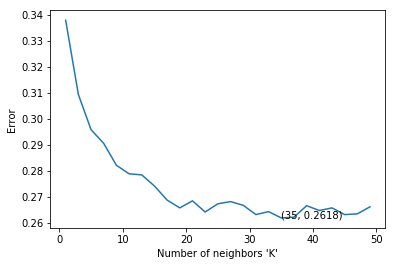

In [319]:
error = []

for a in CV_Scores:
    x = 1 - a
    error.append(x)
    
plot.plot(neighbors, error)

minError1 = min(error)
minError = np.round(minError1, 4)

plot.xlabel("Number of neighbors 'K'")
plot.ylabel("Error")
for xy in zip(neighbors, np.round(error,4)):
    if xy == (best_k, minError):
        plot.annotate(xy,xy)

plot.show()

In [320]:
KNN_best = KNeighborsClassifier(n_neighbors = best_k, algorithm = 'brute')

KNN_best.fit(X_tfidfW2V_1, Y_tfidfW2V_1)

prediction = KNN_best.predict(X_tfidfW2V_test)

accuracyTest = accuracy_score(Y_tfidfW2V_test, prediction) * 100

print("Accuracy of the knn classifier for best k values of "+str(best_k)+" is: "+str(accuracyTest)+"%")

Accuracy of the knn classifier for best k values of 35 is: 75.63333333333333%


### KD Tree Implementation

In [321]:
KNN_best = KNeighborsClassifier(n_neighbors = best_k, algorithm = 'kd_tree')

KNN_best.fit(X_tfidfW2V_1, Y_tfidfW2V_1)

prediction = KNN_best.predict(X_tfidfW2V_test)

accuracyTest = accuracy_score(Y_tfidfW2V_test, prediction) * 100

print("Accuracy of the knn classifier for best k values of "+str(best_k)+" is: "+str(accuracyTest)+"%")

Accuracy of the knn classifier for best k values of 35 is: 75.63333333333333%


## Final Verdict

**Average W2V: Accuracy of the knn classifier for best k values of 29 is: 76.46666666666667%**

**TFIDF-W2V: Accuracy of the knn classifier for best k values of 35 is: 75.63333333333333%**

**Bag of Words: Accuracy of the knn classifier for best k values of 11 is: 65.3%**

**TFIDF: Accuracy of the knn classifier for best k values of 37 is: 49.733333333333334%**